```
This software is part of GPU Ocean. 

Copyright (C) 2018, 2019 SINTEF Digital
Copyright (C) 2018 Norwegian Meteorological Institute

This notebook implements a test to investigate computational performance for
different block sizes for all four numerical schemes, which is required to find
optimal block sizes for performance benchmarking of the schemes.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# Performance: Block Size Experiment

This notebook runs a few timesteps of each of the four numerical schemes on a range of different CUDA block sizes.
The efficiency of each simulation run is reported in a text file, which is later read and processed to obtain the most efficient block sizes on the GPU on your given system.

### To look at the results shown in the paper
Execute the cells below to read the results obtained for the paper and reproduce the optimalization results.

### To find your own optimal block sizes
Comment out the second to last line in the second cell (which overwrites the `test_filename` variable) in order to produce your own benchmark results. Optimal block sizes are typically not the same across different GPUs, so your results might differ from those reported in the paper.


In [1]:
%matplotlib inline

import re
import numpy as np
import pandas as pd
import subprocess
import os
import os.path
import time

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [2]:
# Generate unique filename
test_filename = "blocksize_benchmark_run_0.txt"
file_test = 0
while (os.path.isfile(test_filename)):

    test_filename = "blocksize_benchmark_run_" + str(file_test) + ".txt"
    file_test += 1
    
    
#Use the existing file, do not generate new data
#test_filename = "blocksize_benchmark_run_17.txt"
#test_filename = "blocksize_benchmark_laptop_CDKLM.txt"
test_filename = "met_p100/power_block_size_1/"
print("Storing data in " + test_filename)

Storing data in blocksize_benchmark_run_17.txt


In [3]:
# Specify python command:
python = "python"
#python = "/home/havahol/miniconda3/envs/gpuocean/bin/python"

In [4]:
def runBenchmark(filename):
    sim = np.array(["FBL", "CTCS", "CDKLM"])
    #sim = np.array(["CDKLM", "CTCS", "FBL", "KP"])
    #sim = np.array(["FBL"])
    block_width = np.array([4, 8, 12, 16, 24, 32])
    block_height = np.array([4, 8, 12, 16, 24, 32])
    #block_width=list(range(2,33,1))
    #block_height=list(range(2,33,1))
    
    print("Running with the following:")
    print("Widths: " + str(block_width))
    print("Heights: " + str(block_height))

    block_width, block_height = np.meshgrid(block_width, block_height)
    
    with open(test_filename, 'w') as test_file:
        for k in range(len(sim)):
            test_file.write("##########################################################################\n")
            test_file.write("Using simulator " + sim[k] + ".\n")
            test_file.write("##########################################################################\n")
            for j in range(block_width.shape[1]):
                for i in range(block_width.shape[0]):
                    
                    tic = time.time()
                    
                    test_file.write("=========================================\n")
                    test_file.write(sim[k] + " [{:02d} x {:02d}]\n".format(block_width[i,j], block_height[i,j]))
                    test_file.write("-----------------------------------------\n")
                    cmd = [ python, "run_benchmark.py", 
                           "--block_width", str(block_width[i,j]), "--block_height", str(block_height[i,j]),
                           "--simulator", sim[k], #, "--nx", "100", "--ny", "100", 
                           "--steps_per_download", "500"]
                    p = subprocess.Popen(cmd, shell=False, stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
                    output = p.stdout.read()
                    test_file.write(str(output) + "\n")
                    test_file.write("=========================================\n")
                    test_file.write("\n")
                    
                    toc = time.time()
                    
                    infostr = sim[k] + " [{:02d} x {:02d}] completed in {:.02f} s\n".format(block_width[i,j], block_height[i,j], (toc-tic))
                    test_file.write(infostr)
                    print(infostr)
                    
            test_file.write("\n\n\n")
            test_file.flush()
            os.fsync(test_file)


if not (os.path.isfile(test_filename)):
    runBenchmark(test_filename)
else:
    print("Using existing run in " + test_filename)

Running with the following:
Widths: [ 4  8 12 16 24 32]
Heights: [ 4  8 12 16 24 32]
FBL [04 x 04] completed in 6.74 s

FBL [04 x 08] completed in 4.45 s

FBL [04 x 12] completed in 3.95 s

FBL [04 x 16] completed in 3.30 s

FBL [04 x 24] completed in 2.97 s

FBL [04 x 32] completed in 2.87 s

FBL [08 x 04] completed in 4.26 s

FBL [08 x 08] completed in 3.03 s

FBL [08 x 12] completed in 2.63 s

FBL [08 x 16] completed in 2.49 s

FBL [08 x 24] completed in 2.53 s

FBL [08 x 32] completed in 2.44 s

FBL [12 x 04] completed in 3.44 s

FBL [12 x 08] completed in 2.53 s

FBL [12 x 12] completed in 2.51 s

FBL [12 x 16] completed in 2.47 s

FBL [12 x 24] completed in 2.51 s

FBL [12 x 32] completed in 2.47 s

FBL [16 x 04] completed in 2.92 s

FBL [16 x 08] completed in 2.35 s

FBL [16 x 12] completed in 2.38 s

FBL [16 x 16] completed in 1.95 s

FBL [16 x 24] completed in 2.09 s

FBL [16 x 32] completed in 2.38 s

FBL [24 x 04] completed in 2.53 s

FBL [24 x 08] completed in 2.39 s

FBL [

In [5]:
def getData(filename):
    # State variables
    simulator = None
    block_width = None
    block_height = None

    data = np.empty((0, 4))

    with open(filename) as origin_file:
        for line in origin_file:
            line = str(line)

            # Find simulator
            match = re.match('Using simulator (.+)\.', line)
            if match:
                simulator = match.group(1)
                
            if simulator == None:
                continue

            # Find block size
            match = re.match(simulator + ' \[(\\d+) x (\\d+)\]$', line)
            if match:
                block_width = match.group(1)
                block_height = match.group(2)

            # Find simulator megacells
            match = re.match('.*Maximum megacells: (\\d+(\.\\d+)?)', line)
            if match:
                megacells = match.group(1)
                data = np.append(data, [[simulator, block_width, block_height, megacells]], axis=0)
                
                block_width = None
                block_height = None

    return data

data = getData(test_filename)
print(data)

[['FBL' '04' '04' '404.45656309']
 ['FBL' '04' '08' '707.73933439']
 ['FBL' '04' '12' '849.44639512']
 ['FBL' '04' '16' '1140.01670636']
 ['FBL' '04' '24' '1447.53172979']
 ['FBL' '04' '32' '1519.31484085']
 ['FBL' '08' '04' '771.25039553']
 ['FBL' '08' '08' '1324.36914671']
 ['FBL' '08' '12' '1860.78233735']
 ['FBL' '08' '16' '2053.20418130']
 ['FBL' '08' '24' '1998.36947457']
 ['FBL' '08' '32' '2122.28872333']
 ['FBL' '12' '04' '1051.95925605']
 ['FBL' '12' '08' '1962.67586519']
 ['FBL' '12' '12' '2067.85312808']
 ['FBL' '12' '16' '2131.03885403']
 ['FBL' '12' '24' '2111.54206769']
 ['FBL' '12' '32' '2128.85873279']
 ['FBL' '16' '04' '1452.62688382']
 ['FBL' '16' '08' '2417.12198511']
 ['FBL' '16' '12' '2329.20114282']
 ['FBL' '16' '16' '2465.45996689']
 ['FBL' '16' '24' '2196.19291194']
 ['FBL' '16' '32' '2277.13643600']
 ['FBL' '24' '04' '1976.22467393']
 ['FBL' '24' '08' '2309.84863829']
 ['FBL' '24' '12' '2360.87099603']
 ['FBL' '24' '16' '2211.84421052']
 ['FBL' '24' '24' '1968.

['04' '08' '12' '16' '24' '32']
CDKLM
         04       08       12       16       24       32
04  137.809  218.429  252.082  299.344  310.974  323.415
08  243.033  361.521  401.203  417.677  423.469  395.224
12  311.013  397.362  428.612   438.91  423.054   415.71
16  374.127  448.029  463.356  425.188  436.831  386.988
24  388.868  458.474  443.085  442.829  404.842  292.463
32  463.629  497.249  509.005   454.87  330.903  388.875
Maximum=509.01
Minimum=137.81
Mean=383.57
[ 7. 10.]
CTCS
         04       08       12       16       24       32
04  383.526  657.801  802.397  1054.41  1170.34  1181.46
08  727.722  1273.41  1499.22  1515.33  1365.99  1440.47
12  1021.98  1595.55  1497.34  1455.45  1412.94  1350.86
16  1420.49  1746.04  1573.12  1684.52  1441.18  1241.31
24   1687.2  1589.74   1550.8  1500.18  1367.57  904.143
32  1898.56  1850.37   1650.3  1453.85  1016.69  1214.13
Maximum=1898.56
Minimum=383.53
Mean=1338.79
[ 7. 10.]
FBL
         04       08       12       16       24  

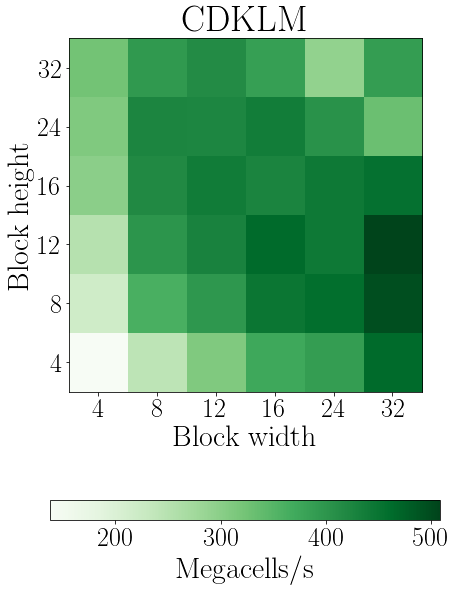

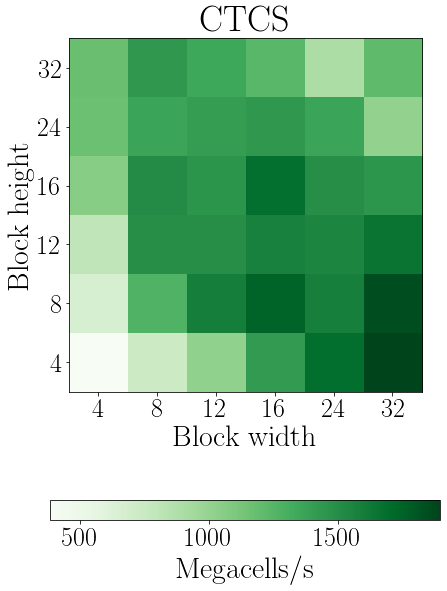

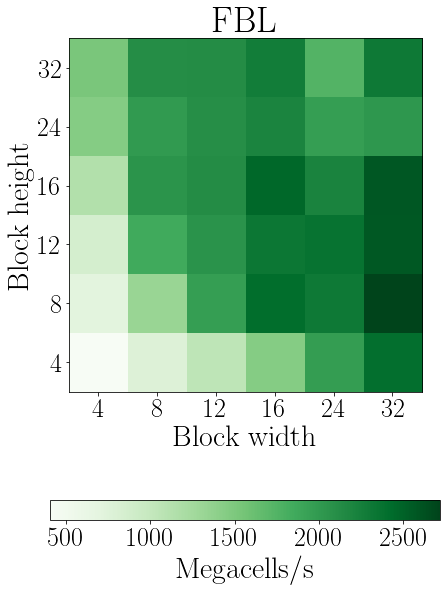

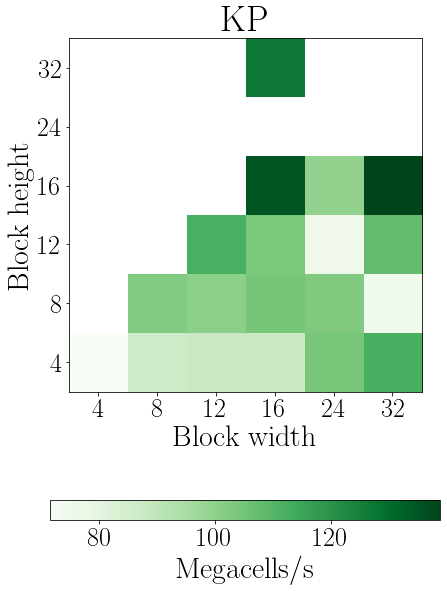

In [6]:
simulators = np.unique(data[:,0])
block_widths = np.unique(data[:,1])
block_heights = np.unique(data[:,2])

print(block_widths)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

for simulator in simulators:
    print(simulator)
    
    df = pd.DataFrame(index=block_widths, columns=block_heights)

    # Pick this simulator data only and sort into a dataframe
    columns = data[:,0] == simulator
    for record in data[columns]:
        block_width = record[1]
        block_height = record[2]
        megacells = np.float32(record[3])
        df[block_height][block_width] = megacells
        
    maximum = np.nanmax(df.values)
    minimum = np.nanmin(df.values)
    mean = np.nanmean(df.values)
    print(df)
    print("Maximum={:.2f}".format(maximum))
    print("Minimum={:.2f}".format(minimum))
    print("Mean={:.2f}".format(mean))

    # Plot dataframe
    x = df.index.values.astype(np.int)
    y = df.columns.values.astype(np.int)
    z = np.transpose(df.values.astype(np.float32))
    
    fontsize=30
    fig = plt.figure(figsize=(7,10))
    ax = fig.add_subplot(111)
    img = ax.imshow(z, origin='lower', cmap=cm.Greens, interpolation="None")
    
    plt.xticks( range(len(x)), x, fontsize=fontsize-4)
    ax.set_xlabel('Block width', fontsize=fontsize)
    plt.yticks( range(len(y)), y, fontsize=fontsize-4)
    ax.set_ylabel('Block height', fontsize=fontsize)

    cb = plt.colorbar(img, orientation="horizontal", pad=0.2)
    cb.ax.tick_params(labelsize=fontsize-4)
    #cb.ax.set_ylabel('Megacells/s')#, rotation=270)
    cb.set_label('Megacells/s', fontsize=fontsize)#, labelpad=-40, y=0.45)



    
    #plt.title(simulator + " [megacells/s]", fontsize=fontsize+6)
    plt.title(simulator, fontsize=fontsize+6)
    fig.savefig(test_filename.replace('.txt', '_'+simulator+'.pdf'))
    print(fig.get_size_inches())

In [7]:
print(test_filename.replace('.txt', '_cdklm.pdf'))

blocksize_benchmark_run_17_cdklm.pdf
